In [ ]:
# DDoS Detection Model Training
# Run this in Google Colab

# Step 1: Install and import libraries
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

Step 2: Loading dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')


Saving Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv to Friday-WorkingHours-Afternoon-DDos.pcap_ISCX (2).csv


In [ ]:
df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')


# Data cleaning


In [ ]:
print("Original shape:", df.shape)
df = df.dropna(axis=1, how='all')  # Remove empty columns
df = df.dropna()  # Remove rows with missing values
print("Cleaned shape:", df.shape)


Original shape: (225745, 85)
Cleaned shape: (225741, 85)


In [ ]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
# 🧹 Data cleaning
print("Original shape:", df.shape)

# Drop empty columns and rows with missing values
df = df.dropna(axis=1, how='all')
df = df.dropna()

print("Cleaned shape:", df.shape)


Original shape: (225741, 85)
Cleaned shape: (225741, 85)


In [ ]:
# 🔄 Convert 'Label' column: BENIGN = 0, DDoS = 1
df['Label'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in x.upper() else 1)


In [ ]:
# 📊 Select relevant features
features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Flow Bytes/s',
    'Flow Packets/s', 'Packet Length Mean', 'Packet Length Std',
    'FIN Flag Count', 'SYN Flag Count', 'ACK Flag Count'
]

# ✅ Only keep available features
available_features = [f for f in features if f in df.columns]
X = df[available_features]
y = df['Label']
# Clean infinite or extremely large values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y[X.index]  # Align labels with cleaned features



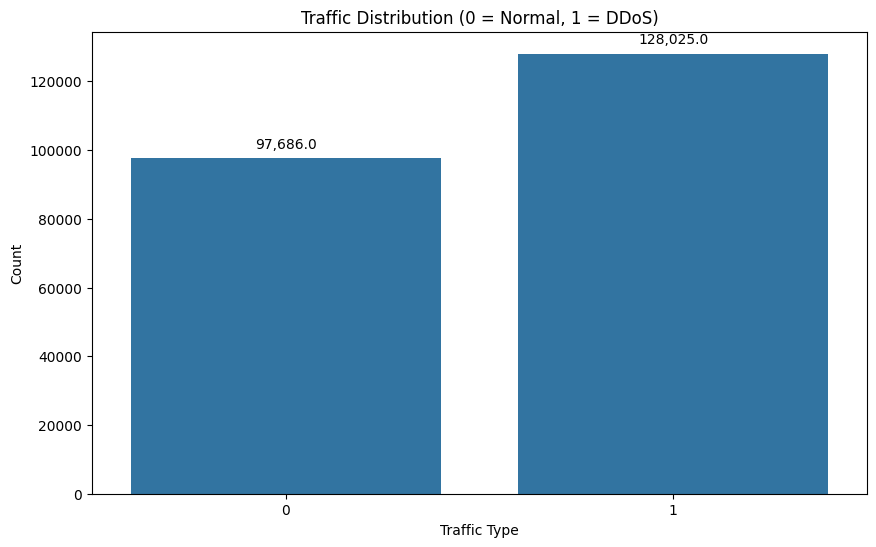

In [ ]:
# 📊 Class distribution (0 = Normal, 1 = DDoS)
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Traffic Distribution (0 = Normal, 1 = DDoS)')
plt.xlabel('Traffic Type')
plt.ylabel('Count')

# 🔢 Annotate count values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.savefig('traffic_distribution.png', dpi=300)
plt.show()


In [ ]:
# 🧪 Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 180568, Test size: 45143


In [ ]:
# 🤖 Train Random Forest, XGBoost, and SVM
from sklearn.svm import LinearSVC

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "SVM": LinearSVC(max_iter=10000, random_state=42)  # faster, remove probability=True
}


results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 📏 Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # 💾 Save model
    joblib.dump(model, f'{name.replace(" ", "_").lower()}.pkl')
    print(f"{name} trained and saved!")

    # 📉 Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'DDoS'],
                yticklabels=['Normal', 'DDoS'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
